In [3]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [4]:
path = 'Data/Variants/SIR/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files['대구']
data

,stdDay,Susceptible,Alpha_Infected,Alpha_Recovered,Alpha_Dead,Alpha_alpha,Alpha_beta,Alpha_gamma,Delta_Infected,Delta_Recovered,Delta_Dead,Delta_alpha,Delta_beta,Delta_gamma
0,2021-04-12,2380065,39.65,163.36,2.00,0.059242,0.058260,0.005296,0.32,0.00,0.00,0.564647,0.000000,0.0
1,2021-04-13,2380056,39.47,165.67,2.21,0.072737,0.079807,0.000000,0.50,0.00,0.00,0.441681,0.000000,0.0
2,2021-04-14,2380045,39.18,168.82,2.21,0.119906,0.037519,0.000000,0.72,0.00,0.00,0.501913,0.000000,0.0
3,2021-04-15,2380027,42.39,170.29,2.21,0.024628,0.084218,0.000000,1.08,0.00,0.00,0.074358,0.000000,0.0
4,2021-04-16,2380023,39.86,173.86,2.21,0.078574,0.052684,0.000000,1.16,0.00,0.00,0.207690,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2021-08-11,2376752,12.67,486.64,3.05,0.030942,0.132597,0.000000,814.69,726.09,0.84,0.045715,0.052928,0.0
122,2021-08-12,2376713,11.38,488.32,3.05,0.050350,0.163445,0.000000,808.62,769.21,0.84,0.067316,0.059039,0.0
123,2021-08-13,2376656,10.09,490.18,3.05,0.081696,0.136769,0.000000,815.03,816.95,0.84,0.096082,0.043459,0.0
124,2021-08-14,2376574,9.53,491.56,3.05,0.060128,0.072403,0.000000,857.51,852.37,0.84,0.063482,0.020653,0.0


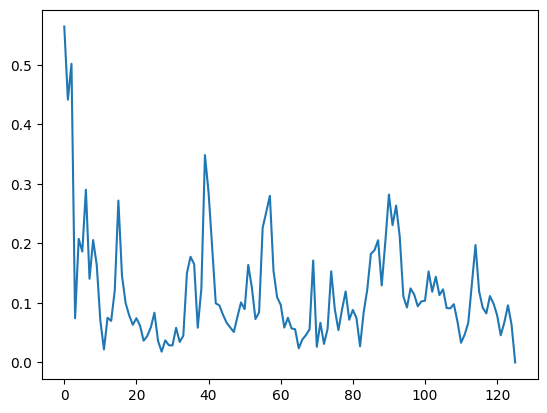

In [5]:
plt.plot(data['Delta_alpha'])

In [6]:
path = 'hyperparameter/SIR/delta/*.pkl'
files = glob.glob(path)
dic_hyperparameter = {}
for file in files:
    dic_hyperparameter[file[25:-4]] = load_hyperparameter(file)
    
dic_hyperparameter

{'BiGRU': [187, 0.001, 20, 8, 64, 8, 0.25],
 'BiLSTM': [366, 0.001, 50, 8, 32, 32, 0.25],
 'BiRNN': [257, 0.001, 50, 8, 32, 8, 0.25],
 'GRU': [280, 0.001, 20, 4, 64, 16, 0.25],
 'LSTM': [424, 0.001, 50, 4, 32, 8, 0.25],
 'RNN': [305, 0.001, 20, 8, 64, 8, 0.25],
 'seq2seq_BiGRU': [963, 0.001, 50, 2, 32, 8, 0.25, MSELoss()],
 'seq2seq_BiLSTM': [183,
  0.001,
  20,
  4,
  64,
  8,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_BiRNN': [900, 0.001, 50, 4, 32, 8, 0.25, MSELoss()],
 'seq2seq_GRU': [853,
  0.001,
  50,
  4,
  32,
  16,
  0.25,
  <function utils.criterion2(actual, predict)>],
 'seq2seq_LSTM': [391, 0.001, 20, 4, 32, 16, 0.25, MSELoss()],
 'seq2seq_RNN': [363,
  0.001,
  20,
  4,
  64,
  32,
  0.25,
  <function utils.criterion3(actual, predict)>]}

In [7]:
dic_model = load_model_multiple(dic_hyperparameter, 'SIR', 'delta')

In [8]:
df = Prepare_df.processing(data, 'stdDay', 'Delta_alpha')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

predicted_values = {}
num_model = 0
for name, state in dic_model.items():
    batch_size = dic_hyperparameter[name][4]
    if num_model < 6:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 57, 60, 1, batch_size, 'mto')
        label_y, predicted = predict_mto(state, df, x_ss, y_ms)
        predicted_values[name] = [label_y, predicted]
    else:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 51, 60, 7, batch_size, 'mtm')
        label_y, predicted, first_label_y, first_predicted, all_predicted = predict_mtm(state, df, x_ss, y_ms, 7, 0.5, device)
        predicted_values[name] = [label_y, predicted, first_label_y, first_predicted, all_predicted]
        
    
    num_model += 1

In [9]:
actual_data = predicted_values['RNN'][0]

0.03875456372139657


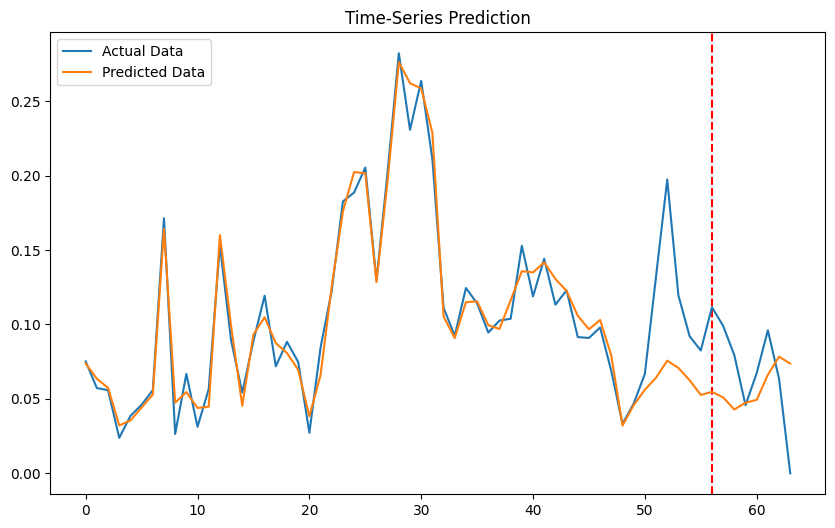

In [10]:
print(rmse(actual_data[-7:], predicted_values['RNN'][1][-7:]))
plotting(actual_data, predicted_values['RNN'][1], 56)

0.04007484709383451


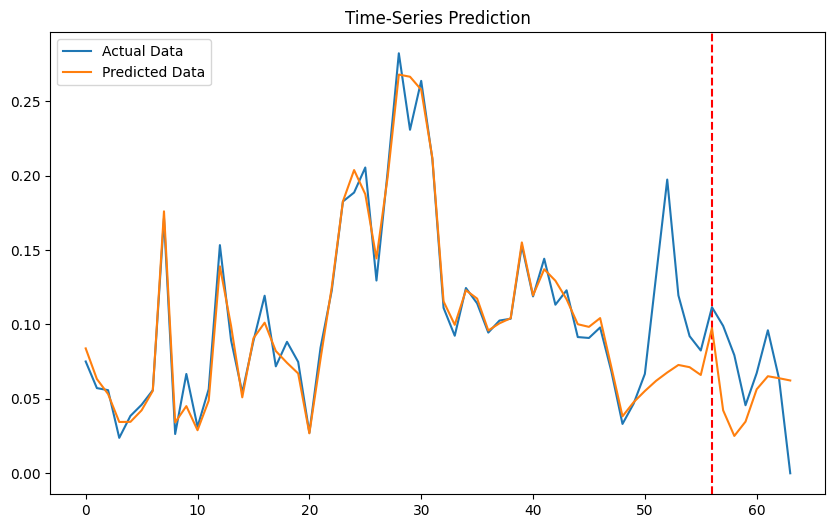

In [11]:
print(rmse(actual_data[-7:], predicted_values['LSTM'][1][-7:]))
plotting(actual_data, predicted_values['LSTM'][1], 56)

0.03451316988311556


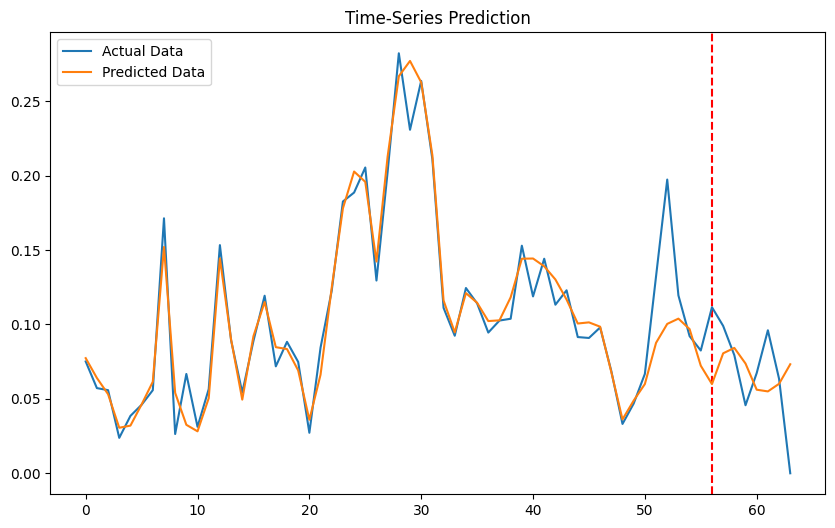

In [12]:
print(rmse(actual_data[-7:], predicted_values['GRU'][1][-7:]))
plotting(actual_data, predicted_values['GRU'][1], 56)

0.02969948572153969


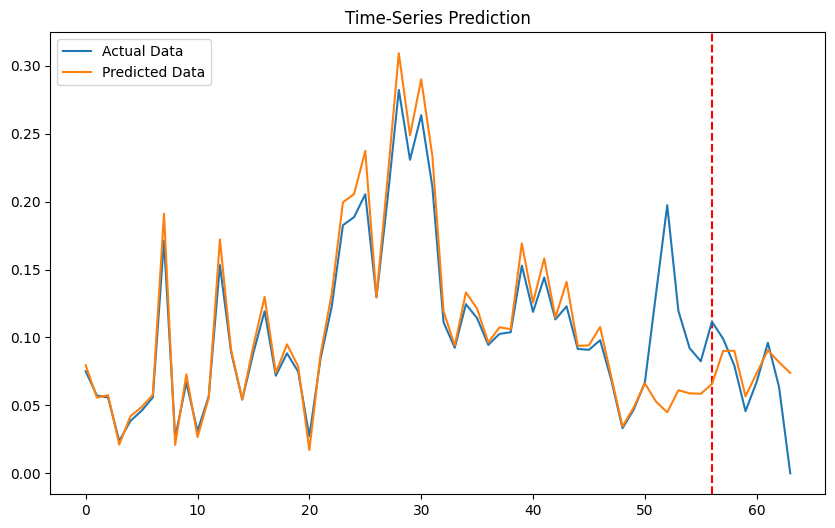

In [13]:
print(rmse(actual_data[-7:], predicted_values['BiRNN'][1][-7:]))
plotting(actual_data, predicted_values['BiRNN'][1], 56)

0.02947294455337322


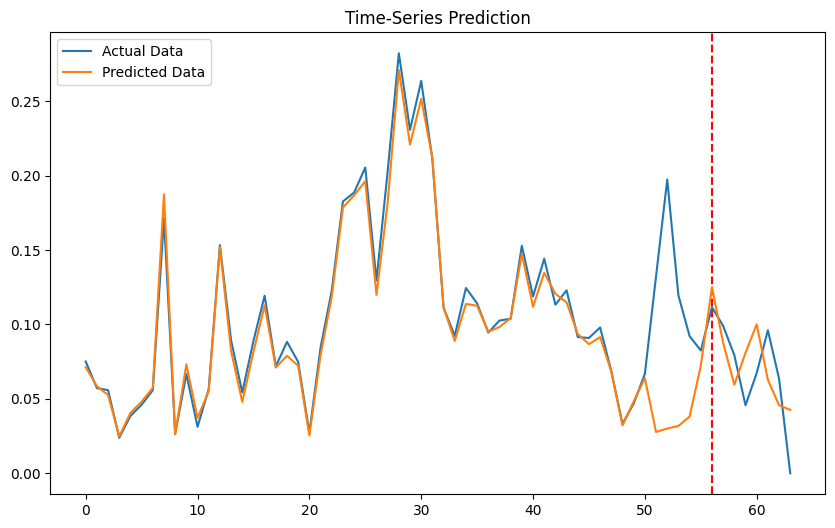

In [14]:
print(rmse(actual_data[-7:], predicted_values['BiLSTM'][1][-7:]))
plotting(actual_data, predicted_values['BiLSTM'][1], 56)

0.03615073294479829


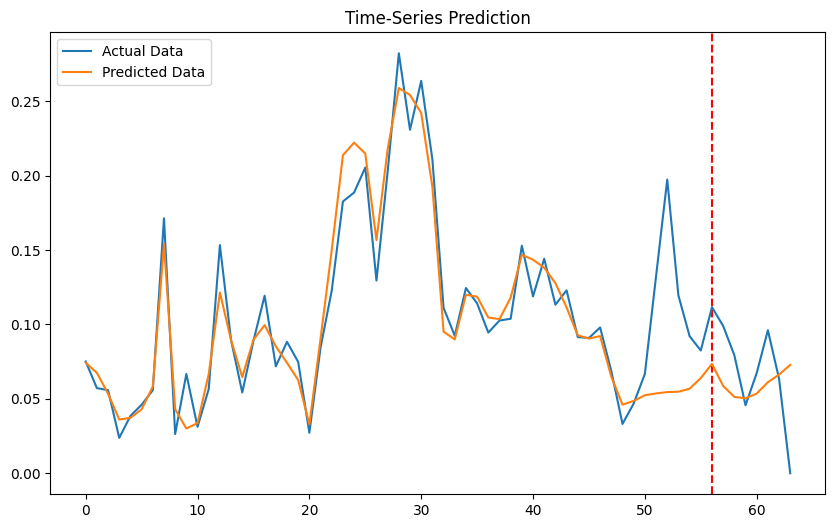

In [15]:
print(rmse(actual_data[-7:], predicted_values['BiGRU'][1][-7:]))
plotting(actual_data, predicted_values['BiGRU'][1], 56)

0.03801953965238617


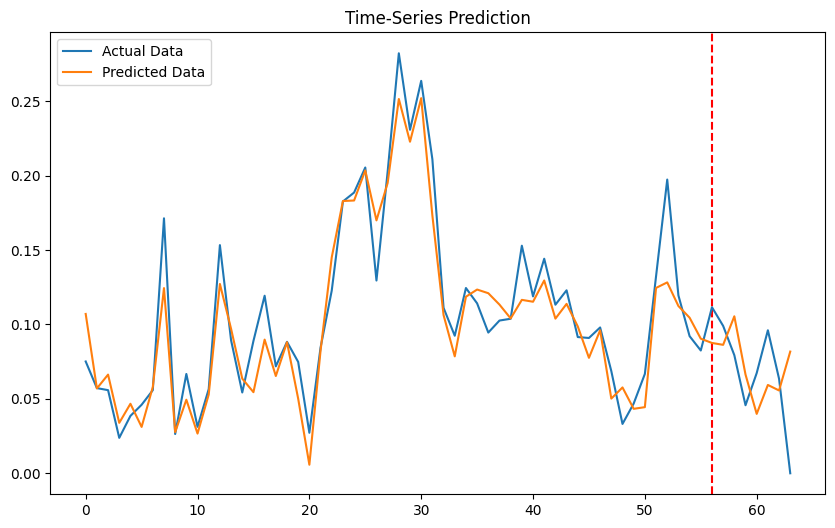

In [16]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_RNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_RNN'][4], 56)

0.031225880613271296


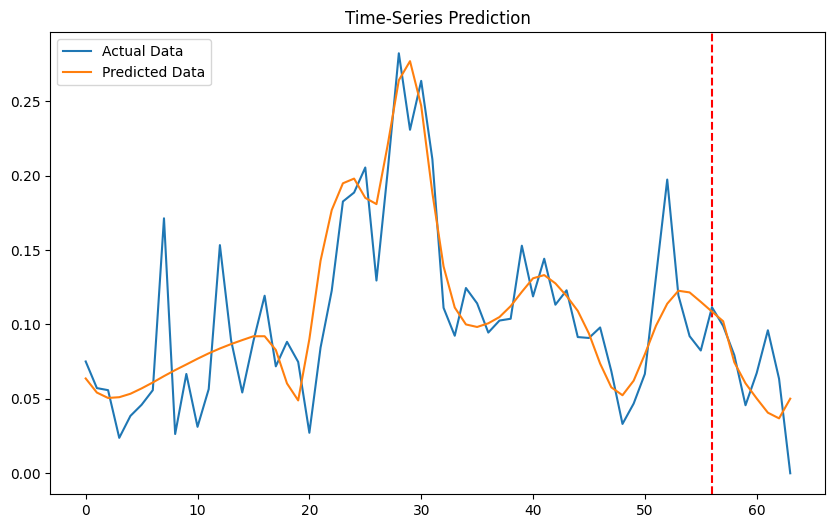

In [17]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_LSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_LSTM'][4], 56)

0.0354753325830254


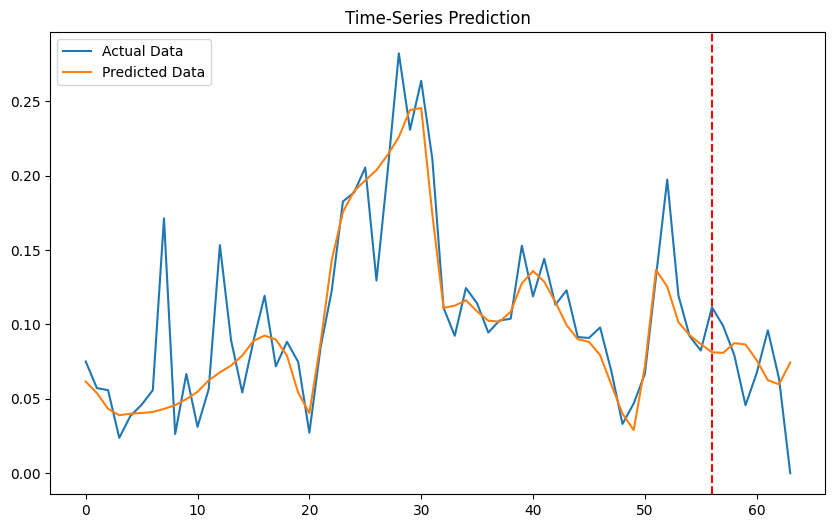

In [18]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_GRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_GRU'][4], 56)

0.02990568702004922


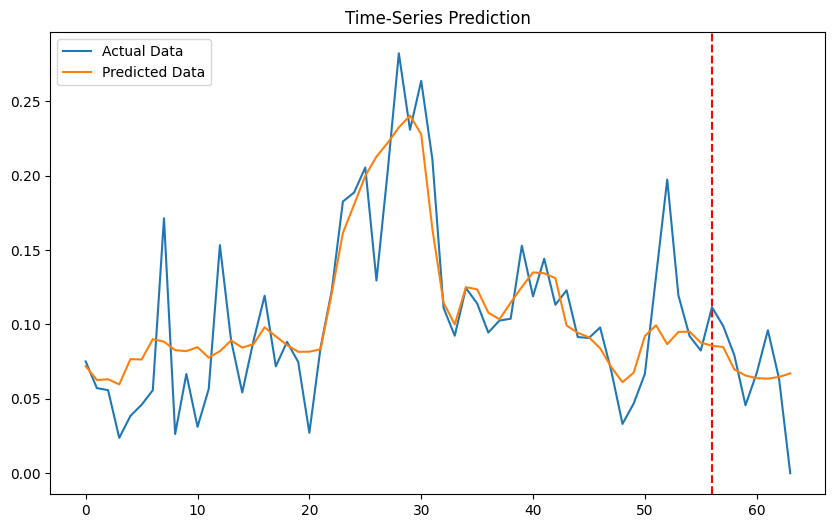

In [19]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiRNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiRNN'][4], 56)

0.03994079341045198


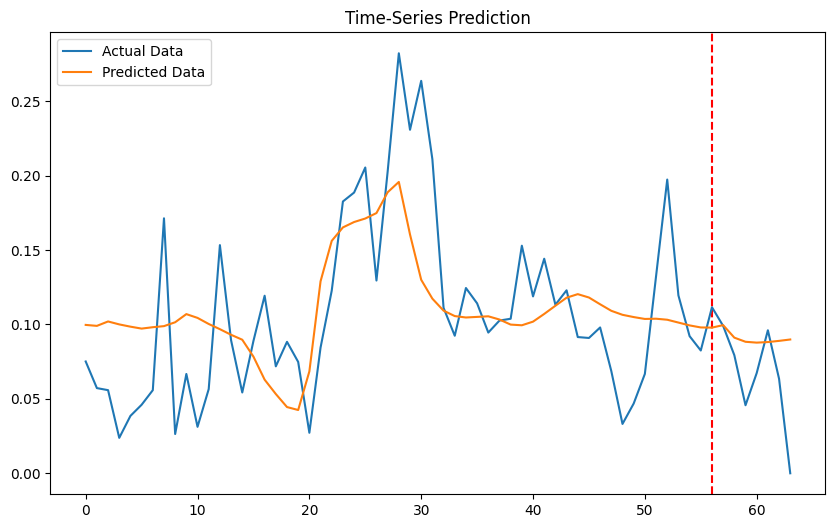

In [20]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiLSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiLSTM'][4], 56)

0.037214939961469705


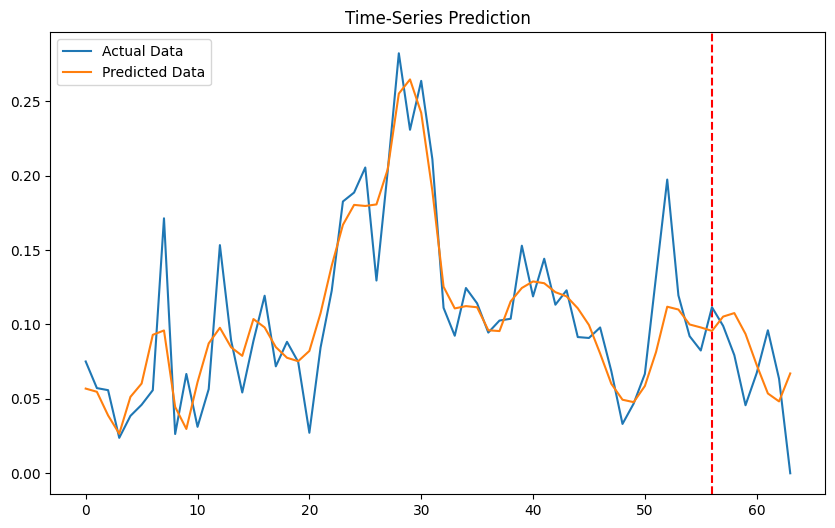

In [21]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiGRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiGRU'][4], 56)

In [28]:
best_model = 'RNN'
datetime_index = data['stdDay'][-1*len(actual_data):]
df_predicted = pd.DataFrame()
df_predicted = pd.DataFrame(np.concatenate([actual_data, predicted_values[best_model][1]], axis = 1), 
                            index = datetime_index, 
                            columns = ['Delta_origin', 'Delta_Predicted'])

df_predicted.to_csv(f'Data/Predicted/Variants/Infected/delta_{best_model}.csv')

In [29]:
df_predicted

,Delta_origin,Delta_Predicted
stdDay,,
2021-06-13,2.100000,2.047840
2021-06-14,2.800000,1.798729
2021-06-15,2.240000,1.986737
2021-06-16,2.240000,1.529873
2021-06-17,0.980000,1.370238
...,...,...
2021-08-11,62.700001,66.417740
2021-08-12,37.049999,54.029575
2021-08-13,54.150002,39.630505
